# Simulation for Potts model
- No interaction (infinite temperature)
- No field
- Preference for low number of colors

- $N$ vertices
- $P(\sigma) = \frac{1}{N^N} \exp((N-n(\sigma))\gamma$), where $n(\sigma) = \text{# of colors used in } \sigma$

- We only consider the interaction on the largest hyperedge on lattice $\Lambda$, where $|\Lambda| = N$
- We assign $\eta_{\Lambda} \in \mathcal{P}(q^N)$ which is in one-to-one correspondence with $\{1,2,...,N\}$
- Each of these corresponds to an energy level in $\{(N-1)\gamma, (N-2)\gamma, ..., 0\}$

- Take $ \upsilon_k =  \frac{e^{((N-k)\gamma)} - e^{((N-k-1)\gamma)}}{e^{((N-1)\gamma)}} $

- Joint distribution
- $Q(\eta, \sigma) = \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} $

- Marginals
- $Q(\eta | \sigma) =  \frac { \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} }{P(\sigma)}$
- $Q(\sigma | \eta) = \frac{1}{|\{\sigma:  \eta(\sigma) \leq \eta(\Lambda)\}|} $

In [1]:
# Initial code from https://rajeshrinet.github.io/blog/2014/ising-model/

import numpy as np 
from numpy.random import rand
from scipy.special import binom

def initial_config(N, no_colors=2):   
    ''' Generate a random color/spin configuration for initialization'''
    state = np.random.randint(no_colors, size=(N,N))
    return state


def mc_move(config, eta_prob, parts, parts_prob, N, q):
    '''Monte Carlo move using generalized SW algorithm '''
    # Assign eta to each hyperedge
    eta = assign_etas(config, eta_prob, q)
#     print('assigned eta:', eta)
    # Assign labels to each site
    config = assign_labels(eta, parts, parts_prob, N, q)
#     print('assigned configuration:\n', config)
    return  config


def number_of_colors (config):
    '''Number of colors used in the given confuration of labels'''
    return len(np.unique(config))


def avg_sites_per_color (config):
    '''Average number of sites each present color has in the configuration'''
    unq = np.unique(config)
    return config.shape[0]*config.shape[1]/len(unq)


def calc_energy(config):
    '''Energy of a given configuration'''
    energy = 0
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j] + config[i,(j-1)%N]
            energy += -nb*S
    return energy/4.


def calc_mag(config):
    '''Magnetization of a given configuration'''
    mag = np.sum(config)
    return mag


def prob_eta(gamma, q, k):
    '''Probability of the eta corresponding to a certain number of colors'''
    if k < q:
        return ( np.exp((q-k)*gamma) - np.exp((q-k-1)*gamma) ) / np.exp((q-1)*gamma)
    elif k == q:
        return 1 / np.exp(gamma*(q-1))

    
def lengths_of_partition(partition):
    '''Lengths of equal subtrings in a partition'''
    lengths = []
    cnt = 0
    curr = partition[0]
    for i in range(len(partition)):
        if partition[i] == curr:
            cnt += 1
            if i == len(partition)-1:
                lengths.append(cnt)
        else:
            lengths.append(cnt)
            cnt = 1
            curr = partition[i]
            if i == len(partition)-1:
                lengths.append(cnt)
    return tuple(lengths)


def multinomial(params):
    if len(params) == 1:
        return 1
#     print (sum(params), params[0])
    return binom(sum(params), params[0]) * multinomial(params[1:])


def prob_of_partition(partition, no_sites, no_colors):
    '''Probability of a given partition'''
    p = partition
    l = ll = lengths_of_partition(p)
    if sum(l) < no_colors: ll = l + (no_colors-sum(l),)
    m1 = multinomial(ll)
    m2 = multinomial(p)
#     print(p, m1, m2, m1*m2)
#     print(l)
#     print(ll)
#     print()
    return m1*m2

    
def assign_etas(config, prob, q):
    '''Assign a number of colors that is at least the current number of colors, with correct probabilities'''
    current_k = number_of_colors(config)
#     print('current no. of colors:', current_k)
    p = prob[current_k-1:]
#     print('probabilities for no. of colors:', p)
    p = p / p.sum()
# #     print('normalized:', p)
    return np.random.choice((np.arange(current_k, q+1)), p=p)


def assign_labels(max_colors, parts, prob, N, q):
    '''Assign a color configuration that has at most the corresponding number of eta'''
    # Brute force version
#     config = initial_config(N, q)
#     while number_of_colors(config) > max_colors:
#         config = initial_config(N, q)
#     return config
    
    idx_max_color = len(parts)                  # index of first occurence of a partition with more than max_colors
    for i in range(len(parts)):
        if len(parts[i]) > max_colors:
            idx_max_color = i
            break
    
#     print('max colors:', max_colors)
#     print('partitions:', parts)
#     print('idx of partition with max color:', idx_max_color)
    p = np.array(prob[:idx_max_color])
#     print('probabilities for partitions:', p)
    p = p / p.sum()
#     print('normalized:', p)
    if idx_max_color > 1: chosen_part = np.random.choice(parts[:idx_max_color], p=p)
    else: chosen_part = parts[0]
#     print('chosen partition:', chosen_part)
        
    # Choose the colors to be used
    chosen_colors = np.random.choice(q, len(chosen_part), replace=False)
#     print('chosen colors:', chosen_colors)

    # Choose a random permutation of the given word
    color_arr = []
    for i in range(len(chosen_part)): color_arr += [chosen_colors[i]]*chosen_part[i]
    color_arr = np.array(color_arr)
#     print('color array:\n', color_arr)
    config = np.random.permutation(color_arr).reshape(N,N)
    return config

In [2]:
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr

def init_partitions(N, q):
    session = WolframLanguageSession()
    parts = session.evaluate(wl.IntegerPartitions(N*N,q))
    print(parts)

    sorted_p = tuple(sorted(parts, key=lambda x: len(x)))
    print(sorted_p)

    part_prob = tuple([prob_of_partition(p, N*N, q) for p in sorted_p])
    print(part_prob)
    print(sum(part_prob), q**(N*N))
    print(q**(N*N)-sum(part_prob))
    part_prob = tuple(part_prob / sum(part_prob))
    print(part_prob)
    return sorted_p, part_prob

    session.terminate()

## Experiment routine

In [3]:
# Small experiment

N, q = 3, 4
sorted_p, part_prob = init_partitions(N, q)
gamma = 2.5
print('Initialization done')
print()

eta_prob = np.zeros(q)
for j in range(q):
    eta_prob[j] = prob_eta(gamma,q,j+1)
print('eta probabilities:', eta_prob)

config = initial_config(N,q)
# config = np.array([[0,0],[0,0]])
print('initial config:\n', config)
config = mc_move(config, eta_prob, sorted_p, part_prob, N, q)

((9,), (8, 1), (7, 2), (7, 1, 1), (6, 3), (6, 2, 1), (6, 1, 1, 1), (5, 4), (5, 3, 1), (5, 2, 2), (5, 2, 1, 1), (4, 4, 1), (4, 3, 2), (4, 3, 1, 1), (4, 2, 2, 1), (3, 3, 3), (3, 3, 2, 1), (3, 2, 2, 2))
((9,), (8, 1), (7, 2), (6, 3), (5, 4), (7, 1, 1), (6, 2, 1), (5, 3, 1), (5, 2, 2), (4, 4, 1), (4, 3, 2), (3, 3, 3), (6, 1, 1, 1), (5, 2, 1, 1), (4, 3, 1, 1), (4, 2, 2, 1), (3, 3, 2, 1), (3, 2, 2, 2))
(4.0, 108.0, 432.0, 1008.0, 1512.0, 864.0, 6048.0, 12096.0, 9072.0, 7560.0, 30240.0, 6720.0, 2016.0, 18144.0, 30240.0, 45360.0, 60480.0, 30240.0)
262144.0 262144
0.0
(1.52587890625e-05, 0.0004119873046875, 0.00164794921875, 0.00384521484375, 0.005767822265625, 0.0032958984375, 0.0230712890625, 0.046142578125, 0.03460693359375, 0.028839111328125, 0.1153564453125, 0.025634765625, 0.0076904296875, 0.0692138671875, 0.1153564453125, 0.17303466796875, 0.230712890625, 0.1153564453125)
Initialization done

eta probabilities: [9.17915001e-01 7.53470516e-02 6.18486263e-03 5.53084370e-04]
initial config:

In [8]:
## change these parameters for a smaller (faster) simulation 
ng      =  101          #  number of gammas to try out
eq_steps = 5005       #  number of MC sweeps for equilibration
mc_steps = 5005       #  number of MC sweeps for calculation

In [9]:
import matplotlib.pyplot as plt

def experiment_for_N (N,q):
    '''Run simulation for different gammas given a lattice size
       N = size of the lattice, N x N
       q = number of colors
    '''
    sorted_p, part_prob = init_partitions(N,q)
    print('Initialization done')
    print()
    gamma = np.linspace(0, 10, ng);
    eta_probs = np.zeros((ng, q))

    for i in range(ng):
        for j in range(q):
            eta_probs[i][j] = prob_eta(gamma[i],q,j+1)
    
    avg_c, avg_s_c = np.zeros(ng), np.zeros(ng)

    for g in range(ng):
        tot_c = tot_s_c = 0
        config = initial_config(N,q)
        eta_prob = eta_probs[g]
        print(g, ' - gamma:', gamma[g])
        print(eta_prob)

        for i in range(eq_steps):           # equilibrate
            config = mc_move(config, eta_prob, sorted_p, part_prob, N, q) # Monte Carlo moves

        for i in range(mc_steps):
            config = mc_move(config, eta_prob, sorted_p, part_prob, N, q)           
            no_cols = number_of_colors(config)       # calculate the energy
            no_sites = avg_sites_per_color(config)         # calculate the magnetisation

            tot_c = tot_c + no_cols
            tot_s_c = tot_s_c + no_sites

            if i%1000==0: print (i+1, tot_c/(i+1), tot_s_c/(i+1))
        
        print(config)
        avg_c[g] = tot_c / (mc_steps)
        avg_s_c[g] = tot_s_c / (mc_steps)
        print(avg_c[g], avg_s_c[g])
        print()
        
    f = plt.figure(figsize=(18, 10)); # plot the calculated values    

    sp =  f.add_subplot(2, 1, 1 );
    plt.scatter(gamma, avg_c, s=50, marker='o', color='IndianRed')
    plt.xlabel("Gamma (g)", fontsize=20);
    plt.ylabel("Avg. no. of colors ", fontsize=20);         plt.axis('tight');

    sp =  f.add_subplot(2, 1, 2 );
    plt.scatter(gamma, avg_s_c, s=50, marker='o', color='RoyalBlue')
    plt.xlabel("Gamma (g)", fontsize=20); 
    plt.ylabel("Avg. sites per color ", fontsize=20);   plt.axis('tight');
    
    plt.show()

((36,), (35, 1), (34, 2), (34, 1, 1), (33, 3), (33, 2, 1), (33, 1, 1, 1), (32, 4), (32, 3, 1), (32, 2, 2), (32, 2, 1, 1), (32, 1, 1, 1, 1), (31, 5), (31, 4, 1), (31, 3, 2), (31, 3, 1, 1), (31, 2, 2, 1), (31, 2, 1, 1, 1), (31, 1, 1, 1, 1, 1), (30, 6), (30, 5, 1), (30, 4, 2), (30, 4, 1, 1), (30, 3, 3), (30, 3, 2, 1), (30, 3, 1, 1, 1), (30, 2, 2, 2), (30, 2, 2, 1, 1), (30, 2, 1, 1, 1, 1), (30, 1, 1, 1, 1, 1, 1), (29, 7), (29, 6, 1), (29, 5, 2), (29, 5, 1, 1), (29, 4, 3), (29, 4, 2, 1), (29, 4, 1, 1, 1), (29, 3, 3, 1), (29, 3, 2, 2), (29, 3, 2, 1, 1), (29, 3, 1, 1, 1, 1), (29, 2, 2, 2, 1), (29, 2, 2, 1, 1, 1), (29, 2, 1, 1, 1, 1, 1), (29, 1, 1, 1, 1, 1, 1, 1), (28, 8), (28, 7, 1), (28, 6, 2), (28, 6, 1, 1), (28, 5, 3), (28, 5, 2, 1), (28, 5, 1, 1, 1), (28, 4, 4), (28, 4, 3, 1), (28, 4, 2, 2), (28, 4, 2, 1, 1), (28, 4, 1, 1, 1, 1), (28, 3, 3, 2), (28, 3, 3, 1, 1), (28, 3, 2, 2, 1), (28, 3, 2, 1, 1, 1), (28, 3, 1, 1, 1, 1, 1), (28, 2, 2, 2, 2), (28, 2, 2, 2, 1, 1), (28, 2, 2, 1, 1, 1, 1), (2

(36.0, 45360.0, 793800.0, 8996400.0, 74220300.0, 475009920.0, 2454217920.0, 10518076800.0, 38128028400.0, 118620532800.0, 320275438560.0, 757014672960.0, 1577113902000.0, 2911594896000.0, 4783334472000.001, 7015557225600.0, 9207918858600.002, 10832845715999.998, 5717335239000.0, 26989200.0, 917632800.0, 10093960800.0, 7570470600.0, 80751686400.0, 161503372800.0, 500660455680.0, 1251651139200.0, 834434092800.0, 2503302278400.0, 7509906835200.0, 12516511392000.0, 10370823724800.0, 36297883036800.0, 72595766073600.0, 45372353796000.0, 36297883036800.0, 145191532147200.0, 338780241676800.0, 508170362515200.0, 108893649110400.0, 490021420996800.0, 1306723789324800.0, 2286766631318400.0, 1372059978791040.0, 283123487687040.0, 1415617438435200.0, 4246852315305600.0, 8493704630611200.0, 1.189118648285568e+16, 643462472016000.0, 3539043596088000.0, 1.179681198696e+16, 2.654282697066e+16, 4.2468523153056e+16, 2.4773305172616e+16, 1286924944032000.0, 7721549664192000.0, 2.8312348768704e+16, 7.078

1 25.0 1.44
1001 22.836163836163838 1.587914896284122
2001 22.87906046976512 1.5846775035977432
3001 22.932355881372875 1.580736069174285
4001 22.95251187203199 1.5793290315293096
5001 22.957008598280343 1.578830340325182
[[ 5 22 13 34  9 17]
 [27  9  1 29 32  8]
 [ 5 23 24 27 12 11]
 [25 10  4 10 26  5]
 [ 7  7 19 13 17 32]
 [26 29 13 23  3  3]]
22.956043956043956 1.5788973389244525

1  - gamma: 0.1
[0.09516258 0.08610666 0.07791253 0.07049817 0.06378939 0.05771902
 0.05222633 0.04725634 0.0427593  0.03869022 0.03500836 0.03167687
 0.02866242 0.02593483 0.0234668  0.02123364 0.01921299 0.01738464
 0.01573027 0.01423334 0.01287885 0.01165327 0.01054431 0.00954089
 0.00863295 0.00781142 0.00706807 0.00639545 0.00578684 0.00523615
 0.00473787 0.004287   0.00387904 0.0035099  0.00317589 0.03019738]
1 21.0 1.7142857142857142
1001 22.61238761238761 1.602926995216553
2001 22.578210894552722 1.6052940320414744
3001 22.54681772742419 1.6076187994273048
4001 22.583354161459635 1.605307652829158

1 20.0 1.8
1001 19.65934065934066 1.8477135505763254
2001 19.73713143428286 1.8406108654565794
3001 19.757080973008996 1.8384134392478024
4001 19.77855536115971 1.8366851662725157
5001 19.75624875024995 1.83969560204105
[[32 12 21 13 35 22]
 [23 34 26 32 22 21]
 [31  7 20 21 30 20]
 [ 1  1 21 22 12 18]
 [22 15 18 22  1 22]
 [34 32 12 21 16 26]]
19.754045954045953 1.8399177410674494

10  - gamma: 1.0
[6.32120559e-01 2.32544158e-01 8.55482149e-02 3.14714295e-02
 1.15776919e-02 4.25919482e-03 1.56687021e-03 5.76419338e-04
 2.12052824e-04 7.80098743e-05 2.86982290e-05 1.05574884e-05
 3.88388295e-06 1.42880069e-06 5.25626399e-07 1.93367146e-07
 7.11357975e-08 2.61693974e-08 9.62718331e-09 3.54164282e-09
 1.30289758e-09 4.79309234e-10 1.76328013e-10 6.48674509e-11
 2.38634016e-11 8.77885484e-12 3.22956021e-12 1.18808881e-12
 4.37073446e-13 1.60790335e-13 5.91514586e-14 2.17606055e-14
 8.00527940e-15 2.94497771e-15 1.08339676e-15 6.30511676e-16]
1 21.0 1.7142857142857142
1001 19.5774225774225

1 15.0 2.4
1001 17.11888111888112 2.1263419810272244
2001 17.031484257871064 2.1367806405250476
3001 16.811396201266245 2.1642224742717664
4001 16.833791552111972 2.160580843680328
5001 16.83403319336133 2.15956445557949
[[ 8 20 12  7 32 15]
 [10 15 23 15  8  7]
 [13 32 22 10 24  7]
 [ 8 33  7 20 28 18]
 [19  3 13  7 20 19]
 [ 3 15 19 13 20 24]]
16.833166833166832 2.1596667017688373

19  - gamma: 1.9000000000000001
[8.50431381e-01 1.27197847e-01 1.90248064e-02 2.84551402e-03
 4.25599604e-04 6.36563450e-05 9.52099163e-06 1.42404157e-06
 2.12991932e-07 3.18569091e-08 4.76479391e-09 7.12663646e-10
 1.06592118e-10 1.59428358e-11 2.38454794e-12 3.56653543e-13
 5.33441780e-14 7.97861505e-15 1.19335044e-15 1.78487777e-16
 2.66961703e-17 3.99290934e-18 5.97213936e-19 8.93244638e-20
 1.33601367e-20 1.99825720e-21 2.98876570e-22 4.47025560e-23
 6.68609957e-24 1.00003068e-24 1.49573208e-25 2.23714582e-26
 3.34606811e-27 5.00466788e-28 7.48541264e-29 1.31648815e-29]
1 18.0 2.0
1001 16.277722277722

1 13.0 2.769230769230769
1001 13.294705294705295 2.7286278949938896
2001 13.148925537231385 2.768439409607032
3001 13.454181939353548 2.7065871972274858
4001 13.427643089227693 2.714605866956006
5001 13.50509898020396 2.698549968408425
[[ 8 13  9  6 11 34]
 [ 9 27 34  1  9  8]
 [14 34 34  9 34  1]
 [ 1 14  6  6 34  7]
 [ 6 13  7 27 29 28]
 [14 13 27 29 15  1]]
13.504695304695305 2.69860645656093

28  - gamma: 2.8000000000000003
[9.39189937e-01 5.71121989e-02 3.47299639e-03 2.11193128e-04
 1.28426673e-05 7.80963406e-07 4.74904336e-08 2.88789624e-09
 1.75613151e-10 1.06790467e-11 6.49393500e-13 3.94896594e-14
 2.40136866e-15 1.46027379e-16 8.87993405e-18 5.39989346e-19
 3.28367859e-20 1.99680701e-21 1.21425959e-22 7.38392018e-24
 4.49016649e-25 2.73047305e-26 1.66040237e-27 1.00969172e-28
 6.13994169e-30 3.73370239e-31 2.27046676e-32 1.38067226e-33
 8.39587665e-35 5.10553785e-36 3.10468076e-37 1.88795832e-38
 1.14806864e-39 6.98141256e-41 4.24540135e-42 2.74878501e-43]
1 14.0 2.571428571

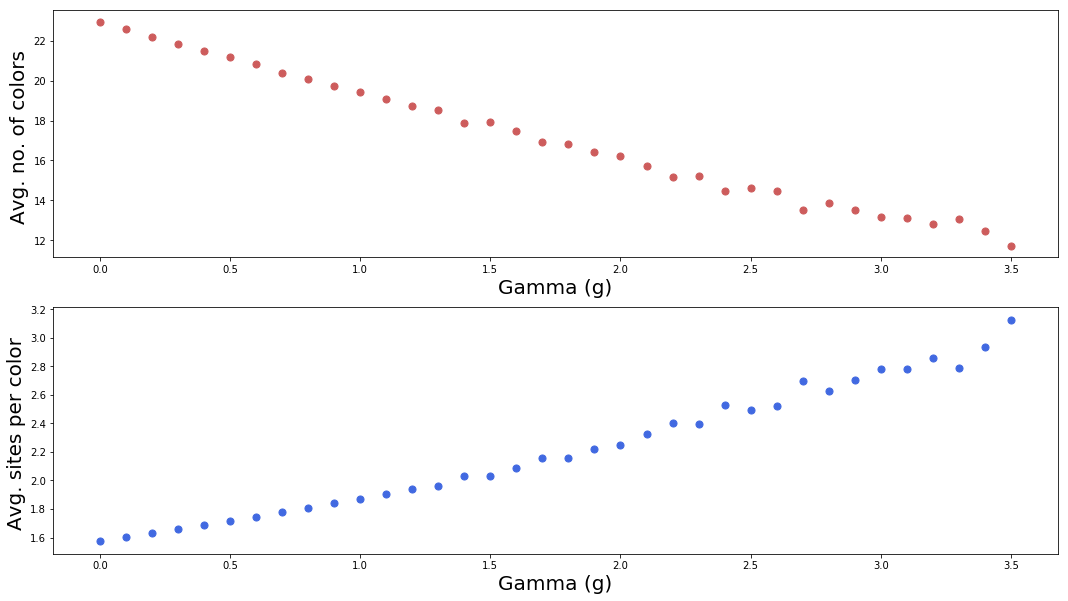

In [10]:
experiment_for_N (6,36) # Non-brute force

((4,), (3, 1), (2, 2), (2, 1, 1), (1, 1, 1, 1))
((4,), (3, 1), (2, 2), (2, 1, 1), (1, 1, 1, 1))
(4.0, 48.0, 36.0, 144.0, 24.0)
256.0 256
0.0
(0.015625, 0.1875, 0.140625, 0.5625, 0.09375)
Initialization done

0  - gamma: 0.0
[0. 0. 0. 1.]
1 3.0 1.3333333333333333
1001 2.7642357642357642 1.5447885447885348
2001 2.7461269365317342 1.5547226386806774
3001 2.7364211929356883 1.5631456181272994
4001 2.736065983504124 1.5616929101057702
5001 2.7360527894421116 1.563020729187433
[[2 1]
 [0 2]]
2.7360639360639363 1.5629703629703

1  - gamma: 0.1
[0.09516258 0.08610666 0.07791253 0.74081822]
1 3.0 1.3333333333333333
1001 2.6923076923076925 1.5840825840825736
2001 2.6936531734132934 1.582875229052159
3001 2.705431522825725 1.577918471620579
4001 2.6970757310672333 1.5845205365324975
5001 2.695460907818436 1.5836832633472688
[[3 3]
 [3 2]]
2.6951048951048953 1.5838827838827223

2  - gamma: 0.2
[0.18126925 0.14841071 0.12150841 0.54881164]
1 3.0 1.3333333333333333
1001 2.6563436563436564 1.61871461

2001 1.8130934532733634 2.5145760453106814
3001 1.7984005331556148 2.541597245362649
4001 1.8045488627843038 2.5290344080646556
5001 1.8038392321535692 2.5305605545557723
[[2 0]
 [2 0]]
1.8045954045954047 2.5297369297369467

24  - gamma: 2.4000000000000004
[9.09282047e-01 8.24882062e-02 7.48316124e-03 7.46585808e-04]
1 2.0 2.0
1001 1.803196803196803 2.494505494505496
2001 1.7596201899050474 2.5698817258037643
3001 1.7744085304898367 2.5585915805842383
4001 1.7935516120969757 2.5245355327834713
5001 1.7992401519696062 2.516630007331878
[[2 2]
 [2 2]]
1.7986013986013987 2.517815517815529

25  - gamma: 2.5
[9.17915001e-01 7.53470516e-02 6.18486263e-03 5.53084370e-04]
1 1.0 4.0
1001 1.8161838161838162 2.471861471861471
2001 1.7661169415292355 2.564717641179408
3001 1.7134288570476508 2.679329112518039
4001 1.7370657335666084 2.6379238523702466
5001 1.727854429114177 2.6486036126108226
[[0 0]
 [2 0]]
1.728071928071928 2.6480852480852595

26  - gamma: 2.6
[9.25726422e-01 6.87570138e-02 5.106

1 2.0 2.0
1001 1.127872127872128 3.744255744255744
2001 1.1664167916041979 3.6684990837914375
3001 1.1792735754748418 3.6423414417416415
4001 1.1659585103724068 3.6687494792968423
5001 1.161367726454709 3.677797773778577
[[0 0]
 [0 0]]
1.1612387612387611 3.6780552780552775

47  - gamma: 4.7
[9.90904723e-01 9.01255304e-03 8.19716673e-05 7.52398299e-07]
1 1.0 4.0
1001 1.1998001998001997 3.6163836163836156
2001 1.1859070464767616 3.636848242545393
3001 1.1966011329556814 3.613462179273575
4001 1.1984503874031491 3.6090977255686076
5001 1.1971605678864228 3.6107445177631137
[[3 3]
 [3 3]]
1.197002997002997 3.611055611055611

48  - gamma: 4.800000000000001
[9.91770253e-01 8.16201831e-03 6.71713461e-05 5.57390369e-07]
1 1.0 4.0
1001 1.2067932067932068 3.5864135864135864
2001 1.1514242878560719 3.698484091287689
3001 1.1626124625124958 3.6756636676663335
4001 1.1522119470132466 3.6962426060151627
5001 1.1489702059588083 3.702592814770379
[[2 2]
 [2 1]]
1.1496503496503496 3.7012321012321006

4

2001 1.056471764117941 3.887056471764118
3001 1.0376541152949017 3.9246917694101966
4001 1.0387403149212697 3.9225193701574605
5001 1.0309938012397522 3.9380123975204957
[[2 2]
 [2 2]]
1.030969030969031 3.938061938061938

70  - gamma: 7.0
[9.99088118e-01 9.11050437e-04 8.30770463e-07 7.58256043e-10]
1 1.0 4.0
1001 1.000999000999001 3.998001998001998
2001 1.0089955022488755 3.982008995502249
3001 1.0159946684438521 3.9680106631122958
4001 1.0134966258435392 3.9730067483129217
5001 1.0187962407518496 3.962407518496301
[[3 3]
 [3 3]]
1.0187812187812189 3.9624375624375623

71  - gamma: 7.1000000000000005
[9.99174895e-01 8.24424125e-04 6.80236405e-07 5.61729892e-10]
1 1.0 4.0
1001 1.001998001998002 3.996003996003996
2001 1.0349825087456272 3.9300349825087455
3001 1.0233255581472842 3.9533488837054316
4001 1.0192451887028242 3.9615096225943516
5001 1.018996200759848 3.962007598480304
[[0 0]
 [0 0]]
1.018981018981019 3.962037962037962

72  - gamma: 7.2
[9.99253414e-01 7.46028418e-04 5.5697423

1 1.0 4.0
1001 1.0 4.0
2001 1.0 4.0
3001 1.0083305564811729 3.9833388870376543
4001 1.0062484378905274 3.987503124218945
5001 1.00499900019996 3.99000199960008
[[1 1]
 [1 1]]
1.004995004995005 3.99000999000999



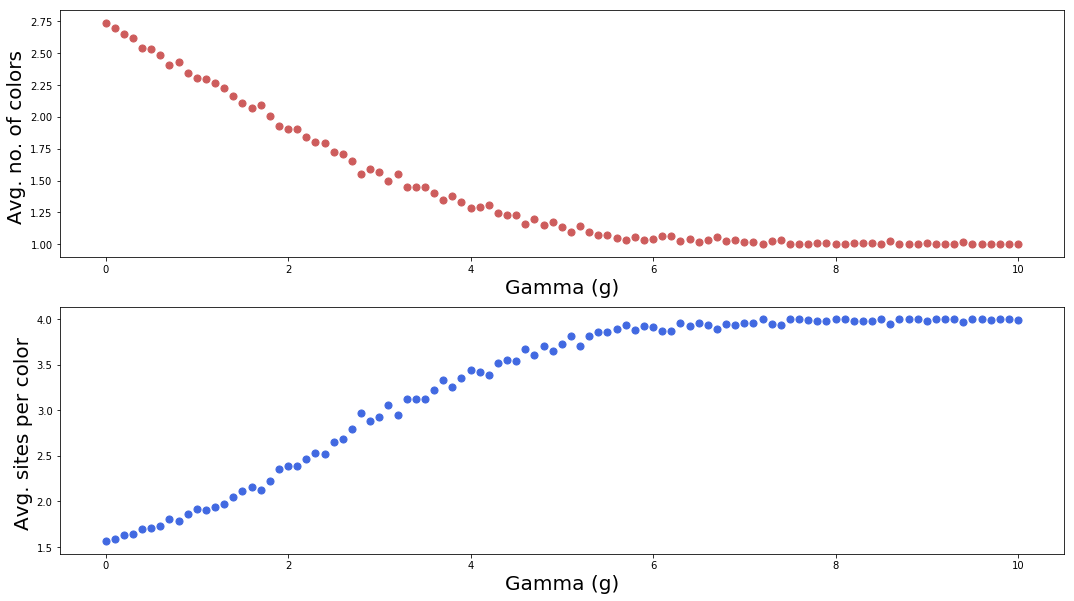

In [10]:
experiment_for_N (2,4) # Non-brute force version

((25,), (24, 1), (23, 2), (23, 1, 1), (22, 3), (22, 2, 1), (22, 1, 1, 1), (21, 4), (21, 3, 1), (21, 2, 2), (21, 2, 1, 1), (21, 1, 1, 1, 1), (20, 5), (20, 4, 1), (20, 3, 2), (20, 3, 1, 1), (20, 2, 2, 1), (20, 2, 1, 1, 1), (20, 1, 1, 1, 1, 1), (19, 6), (19, 5, 1), (19, 4, 2), (19, 4, 1, 1), (19, 3, 3), (19, 3, 2, 1), (19, 3, 1, 1, 1), (19, 2, 2, 2), (19, 2, 2, 1, 1), (19, 2, 1, 1, 1, 1), (19, 1, 1, 1, 1, 1, 1), (18, 7), (18, 6, 1), (18, 5, 2), (18, 5, 1, 1), (18, 4, 3), (18, 4, 2, 1), (18, 4, 1, 1, 1), (18, 3, 3, 1), (18, 3, 2, 2), (18, 3, 2, 1, 1), (18, 3, 1, 1, 1, 1), (18, 2, 2, 2, 1), (18, 2, 2, 1, 1, 1), (18, 2, 1, 1, 1, 1, 1), (18, 1, 1, 1, 1, 1, 1, 1), (17, 8), (17, 7, 1), (17, 6, 2), (17, 6, 1, 1), (17, 5, 3), (17, 5, 2, 1), (17, 5, 1, 1, 1), (17, 4, 4), (17, 4, 3, 1), (17, 4, 2, 2), (17, 4, 2, 1, 1), (17, 4, 1, 1, 1, 1), (17, 3, 3, 2), (17, 3, 3, 1, 1), (17, 3, 2, 2, 1), (17, 3, 2, 1, 1, 1), (17, 3, 1, 1, 1, 1, 1), (17, 2, 2, 2, 2), (17, 2, 2, 2, 1, 1), (17, 2, 2, 1, 1, 1, 1), (1

1 15.0 1.6666666666666667
1001 15.986013986013987 1.5790270223076268
2001 15.96151924037981 1.581647063068008
3001 15.967677440853048 1.5815202135122504
4001 15.955261184703824 1.5824983838347502
5001 15.966006798640272 1.5811675531490321
[[21 24 19  9 23]
 [21 13 16  2 17]
 [21  4  6 19  6]
 [10  3  0 10  1]
 [ 3  8 12  2 12]]
15.966833166833167 1.5810857074881215

1  - gamma: 0.1
[0.09516258 0.08610666 0.07791253 0.07049817 0.06378939 0.05771902
 0.05222633 0.04725634 0.0427593  0.03869022 0.03500836 0.03167687
 0.02866242 0.02593483 0.0234668  0.02123364 0.01921299 0.01738464
 0.01573027 0.01423334 0.01287885 0.01165327 0.01054431 0.00954089
 0.09071795]
1 16.0 1.5625
1001 15.696303696303696 1.608562339385316
2001 15.706146926536732 1.6085404323164219
3001 15.696101299566811 1.6093919055921824
4001 15.691077230692327 1.61009971234273
5001 15.688062387522496 1.6102118956256044
[[23 19  8 15  9]
 [ 3 16  4 11  6]
 [ 1 23 21 21  5]
 [19 14  4  1 18]
 [22  4  3  1 11]]
15.68791208791208

2001 13.409295352323838 1.8889615432868772
3001 13.414195268243919 1.8883384779015542
4001 13.396400899775056 1.8925643767823013
5001 13.38372325534893 1.8943277373611753
[[ 1  2 11 12 10]
 [ 6 24  8  8  6]
 [ 6 19  1 17  1]
 [10 22  1 15 12]
 [ 5 12 14  9 12]]
13.384815184815185 1.8941695761896005

12  - gamma: 1.2000000000000002
[6.98805788e-01 2.10476259e-01 6.33942308e-02 1.90939754e-02
 5.75099487e-03 1.73216637e-03 5.21718484e-04 1.57138588e-04
 4.73292331e-05 1.42552911e-05 4.29361116e-06 1.29321083e-06
 3.89507616e-07 1.17317440e-07 3.53353337e-08 1.06427980e-08
 3.20554916e-09 9.65492852e-10 2.90800859e-10 8.75875354e-11
 2.63808587e-11 7.94576195e-12 2.39321751e-12 7.20823261e-13
 3.10684024e-13]
1 12.0 2.0833333333333335
1001 12.98001998001998 1.9544599956467397
2001 13.079460269865068 1.9387176361722485
3001 13.082972342552482 1.939014590292575
4001 13.003249187703075 1.9501734409835372
5001 13.017196560687863 1.9489876792400564
[[15  0  0 10  4]
 [10  7  4 19 14]
 [14 14  

1 13.0 1.9230769230769231
1001 10.843156843156843 2.364296161436522
2001 10.704147926036981 2.391077882082394
3001 10.737087637454183 2.378720253699399
4001 10.719320169957511 2.385210902222279
5001 10.645070985802839 2.3992569465350195
[[ 1 19 16  1 23]
 [16 23  5  1 20]
 [ 2  2 21 11  5]
 [16 22 21  5  1]
 [16 19 21 19  2]]
10.644555444555445 2.3993374604638626

23  - gamma: 2.3000000000000003
[8.99741156e-01 9.02070080e-02 9.04405032e-03 9.06746027e-04
 9.09093082e-05 9.11446213e-06 9.13805434e-07 9.16170762e-08
 9.18542213e-09 9.20919801e-10 9.23303545e-11 9.25693458e-12
 9.28089557e-13 9.30491859e-14 9.32900379e-15 9.35315133e-16
 9.37736137e-17 9.40163408e-18 9.42596962e-19 9.45036815e-20
 9.47482984e-21 9.49935484e-22 9.52394332e-23 9.54859545e-24
 1.06400728e-24]
1 11.0 2.272727272727273
1001 10.23076923076923 2.4925238486677324
2001 10.559220389805098 2.416199041948698
3001 10.554148617127623 2.414517546765089
4001 10.505373656585853 2.4300085311394715
5001 10.499100179964007 

1 9.0 2.7777777777777777
1001 8.621378621378621 2.933281545294544
2001 8.566216891554223 2.9558308868653285
3001 8.533822059313563 2.972431507919628
4001 8.741314671332168 2.9061018024714187
5001 8.617076584683064 2.958663498180611
[[ 1  9  6 18 22]
 [ 6 17 22  4 20]
 [18 23  4  4 23]
 [ 9 22  1  1 23]
 [20 22  4 17  4]]
8.617982017982017 2.958352434001801

34  - gamma: 3.4000000000000004
[9.66626730e-01 3.22594948e-02 1.07660483e-03 3.59298236e-05
 1.19909570e-06 4.00177446e-08 1.33552299e-09 4.45707694e-11
 1.48747232e-12 4.96418153e-14 1.65670970e-15 5.52898202e-17
 1.84520209e-18 6.15804276e-20 2.05514024e-21 6.85867499e-23
 2.28896412e-24 7.63902175e-26 2.54939135e-27 8.50815258e-29
 2.83944873e-30 9.47616889e-32 3.16250743e-33 1.05543214e-34
 3.64393211e-36]
1 8.0 3.125
1001 8.703296703296703 2.9355240718877202
2001 8.345827086456772 3.0672055747018185
3001 8.265578140619793 3.094714256826871
4001 8.20569857535616 3.1136646581222944
5001 8.241951609678065 3.1012007305498837
[[23 

1 8.0 3.125
1001 7.08991008991009 3.5629549022406
2001 6.848575712143928 3.6926179767259555
3001 6.71242919026991 3.7927701348228045
4001 6.757310672331917 3.761953856773981
5001 6.6630673865226955 3.8596149817656626
[[20 11 10 11  6]
 [20 10 10 18 20]
 [ 6 18 18  6 11]
 [20 11 18 10 18]
 [10 10  6  6 11]]
6.661738261738262 3.860526378383632

45  - gamma: 4.5
[9.88891003e-01 1.09855867e-02 1.22038845e-04 1.35572911e-06
 1.50607900e-08 1.67310263e-10 1.85864914e-12 2.06477268e-14
 2.29375526e-16 2.54813192e-18 2.83071887e-20 3.14464461e-22
 3.49338461e-24 3.88079976e-26 4.31117911e-28 4.78928738e-30
 5.32041769e-32 5.91045017e-34 6.56591705e-36 7.29407498e-38
 8.10298537e-40 9.00160364e-42 9.99987837e-44 1.11088614e-45
 1.24794646e-47]
1 5.0 5.0
1001 6.143856143856143 4.141156462584984
2001 6.653173413293353 3.8642633048554673
3001 6.961679440186605 3.7064740444863338
4001 6.935766058485378 3.7152972759696103
5001 6.945410917816437 3.6936905548183283
[[ 3 17  3  7  3]
 [ 7 18 10  7 16]


1 6.0 4.166666666666667
1001 6.351648351648351 3.966777270348652
2001 6.252873563218391 4.037743033245324
3001 6.35354881706098 4.004885276336478
4001 6.143214196450887 4.158015555634904
5001 5.92741451709658 4.322879471724741
[[ 6  6 21 12  9]
 [21 21 21  6  6]
 [21 10 21  9 16]
 [10 21 16 10 21]
 [16 21 21 12 16]]
5.927472527472528 4.322754626326095

56  - gamma: 5.6000000000000005
[9.96302136e-01 3.68418952e-03 1.36236308e-05 5.03783298e-08
 1.86292198e-10 6.88883160e-13 2.54739604e-15 9.41992339e-18
 3.48335929e-20 1.28809879e-22 4.76321379e-25 1.76137155e-27
 6.51331193e-30 2.40853399e-32 8.90643044e-35 3.29347660e-37
 1.21788276e-39 4.50356447e-42 1.66535677e-44 6.15826236e-47
 2.27724149e-49 8.42092869e-52 3.11394467e-54 1.15149430e-56
 4.27387319e-59]
1 4.0 6.25
1001 4.8901098901098905 5.297202797202849
2001 5.448275862068965 4.784839722995684
3001 5.4161946017994005 4.783425366147737
4001 5.638340414896276 4.603261387034096
5001 5.739452109578084 4.498820474000538
[[20  0  8 1

1 5.0 5.0
1001 6.175824175824176 4.0774701488986675
2001 5.827586206896552 4.353210299612119
3001 5.062312562479174 5.32639913679579
4001 4.79680079980005 5.557241641970549
5001 4.698860227954409 5.623946639243665
[[ 3 18  1  9  3]
 [18  0  0 16  9]
 [ 0 18  1 16  9]
 [18  0  9 16 18]
 [18  3 16 18  9]]
4.6999000999001 5.622781979924923

67  - gamma: 6.7
[9.98769088e-01 1.22939676e-03 1.51327910e-06 1.86271326e-09
 2.29283592e-12 2.82227903e-15 3.47397685e-18 4.27615945e-21
 5.26357557e-24 6.47899782e-27 7.97507553e-30 9.81661540e-33
 1.20833887e-35 1.48735870e-38 1.83080753e-41 2.25356278e-44
 2.77393725e-47 3.41447238e-50 4.20291469e-53 5.17341772e-56
 6.36802145e-59 7.83847340e-62 9.64847020e-65 1.18764168e-67
 1.46368395e-70]
1 5.0 5.0
1001 4.0989010989010985 6.126373626373627
2001 4.451774112943529 5.69777611194401
3001 4.301232922359214 5.881789403532144
4001 4.22594351412147 5.973819045238681
5001 4.353729254149171 5.837165900153366
[[17 12  1 12  1]
 [ 1  7  3  7  3]
 [ 7 12  7

1 5.0 5.0
1001 4.765234765234765 5.293456543456544
2001 4.382808595702149 5.771489255372314
3001 4.255248250583139 5.930939686771076
4001 4.191452136965759 6.010684828792802
5001 4.308538292341532 5.864327134573085
[[10  6 13 10 10]
 [20  5  6 13 20]
 [13 10  5 20 13]
 [20 10  6  5  5]
 [ 5 13 10 13 20]]
4.3090909090909095 5.863636363636363

79  - gamma: 7.9
[9.99629256e-01 3.70606090e-04 1.37399814e-07 5.09400934e-11
 1.88857106e-14 7.00175521e-18 2.59585552e-21 9.62396664e-25
 3.56802347e-28 1.32282165e-31 4.90427583e-35 1.81822858e-38
 6.74096503e-42 2.49916924e-45 9.26550852e-49 3.43512743e-52
 1.27355131e-55 4.72160920e-59 1.75050611e-62 6.48988834e-66
 2.40608418e-69 8.92040167e-73 3.30718130e-76 1.22611610e-79
 4.54743218e-83]
1 5.0 5.0
1001 5.0 5.0
2001 5.0 5.0
3001 4.903698767077641 5.120376541152949
4001 4.787053236690827 5.266183454136466
5001 4.6710657868426315 5.411417716456709
[[13  3 22 22  6]
 [22  3 23 22 17]
 [22 23  6 17  3]
 [22 13 17 22 22]
 [23 22 23 17 22]]
4.672

1 4.0 6.25
1001 4.0 6.25
2001 4.0 6.25
3001 4.0 6.25
4001 4.037240689827543 6.203449137715571
5001 4.029794041191762 6.212757448510298
[[ 1  1  6 16  1]
 [ 3  3 16  3 16]
 [16 16  3 16  6]
 [16  6  6 16  6]
 [ 3 16 16 16 16]]
4.02977022977023 6.212787212787212

91  - gamma: 9.1
[9.99888334e-01 1.11653339e-04 1.24678604e-08 1.39223371e-12
 1.55464903e-16 1.73601141e-20 1.93853117e-24 2.16467651e-28
 2.41720352e-32 2.69918986e-36 3.01407218e-40 3.36568807e-44
 3.75832279e-48 4.19676153e-52 4.68634769e-56 5.23304804e-60
 5.84352540e-64 6.52521989e-68 7.28643954e-72 8.13646162e-76
 9.08564565e-80 1.01455597e-83 1.13291212e-87 1.26507548e-91
 1.41281453e-95]
1 3.0 8.333333333333334
1001 3.0 8.333333333333226
2001 3.2553723138430786 7.80130767949368
3001 3.5034988337220927 7.284377429745702
4001 3.627593101724569 7.025847704740528
5001 3.7020595880823834 6.870709191495072
[[ 7  3  3 23  3]
 [19  3 23 19 19]
 [ 3 19  3  7 23]
 [19  7 23 23 19]
 [ 7 23  7  7 19]]
3.7022977022977024 6.870213120

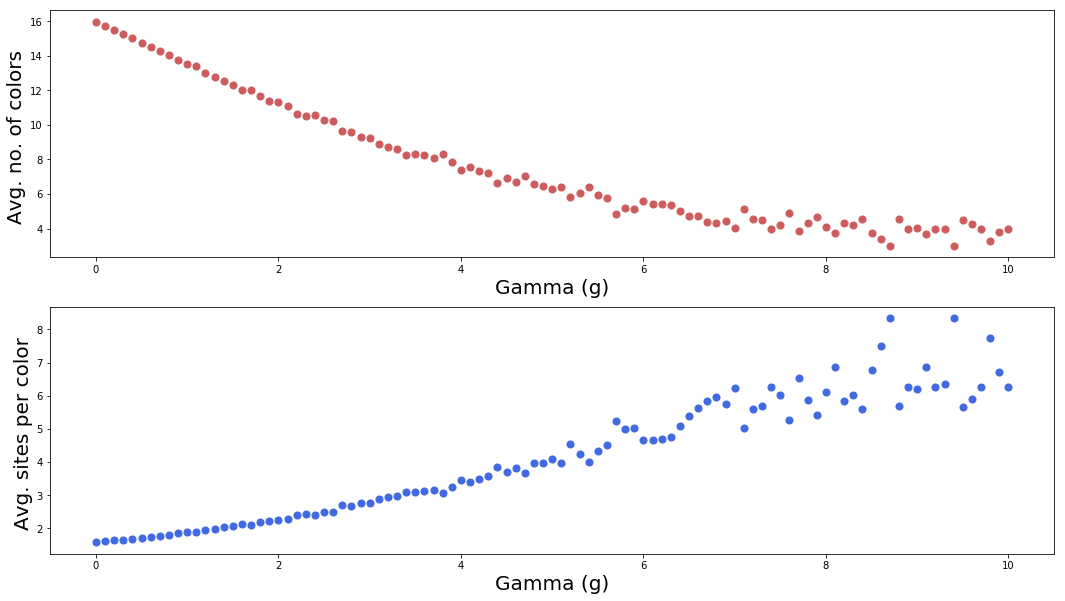

In [11]:
experiment_for_N (5,25) # Non-brute force version

((9,), (8, 1), (7, 2), (7, 1, 1), (6, 3), (6, 2, 1), (6, 1, 1, 1), (5, 4), (5, 3, 1), (5, 2, 2), (5, 2, 1, 1), (4, 4, 1), (4, 3, 2), (4, 3, 1, 1), (4, 2, 2, 1), (3, 3, 3), (3, 3, 2, 1), (3, 2, 2, 2))
((9,), (8, 1), (7, 2), (6, 3), (5, 4), (7, 1, 1), (6, 2, 1), (5, 3, 1), (5, 2, 2), (4, 4, 1), (4, 3, 2), (3, 3, 3), (6, 1, 1, 1), (5, 2, 1, 1), (4, 3, 1, 1), (4, 2, 2, 1), (3, 3, 2, 1), (3, 2, 2, 2))
(4.0, 108.0, 432.0, 1008.0, 1512.0, 864.0, 6048.0, 12096.0, 9072.0, 7560.0, 30240.0, 6720.0, 2016.0, 18144.0, 30240.0, 45360.0, 60480.0, 30240.0)
262144.0 262144
0.0
(1.52587890625e-05, 0.0004119873046875, 0.00164794921875, 0.00384521484375, 0.005767822265625, 0.0032958984375, 0.0230712890625, 0.046142578125, 0.03460693359375, 0.028839111328125, 0.1153564453125, 0.025634765625, 0.0076904296875, 0.0692138671875, 0.1153564453125, 0.17303466796875, 0.230712890625, 0.1153564453125)
Initialization done

0  - gamma: 0.0
[0. 0. 0. 1.]
1 4.0 2.25
1001 3.7312687312687314 2.459040959040959
2001 3.720639

1 4.0 2.25
1001 2.967032967032967 3.1843156843156843
2001 2.9395302348825587 3.270614692653673
3001 2.9636787737420858 3.2369210263245587
4001 2.931267183204199 3.266183454136466
5001 2.9478104379124175 3.237252549490102
[[0 3 1]
 [0 0 2]
 [2 0 0]]
2.9484515484515486 3.236613386613387

22  - gamma: 2.2
[0.88919684 0.09852582 0.01091697 0.00136037]
1 3.0 3.0
1001 2.9390609390609392 3.2262737262737264
2001 2.8865567216391805 3.2991004497751124
3001 2.8977007664111962 3.282405864711763
4001 2.931267183204199 3.2376905773556612
5001 2.9082183563287343 3.266646670665867
[[1 1 3]
 [3 3 2]
 [3 2 2]]
2.9084915084915086 3.2662837162837164

23  - gamma: 2.3000000000000003
[0.89974116 0.09020701 0.00904405 0.00100779]
1 3.0 3.0
1001 2.8811188811188813 3.2772227772227773
2001 2.8800599700149925 3.287106446776612
3001 2.9046984338553816 3.2556647784071977
4001 2.863284178955261 3.3368532866783305
5001 2.8556288742251548 3.3419316136772648
[[0 2 1]
 [2 1 1]
 [2 2 1]]
2.8557442557442556 3.34165834165

4001 2.216445888527868 4.402336915771057
5001 2.2429514097180565 4.318686262747451
[[0 3 3]
 [3 0 3]
 [3 3 0]]
2.242757242757243 4.318831168831169

44  - gamma: 4.4
[9.87722660e-01 1.21266068e-02 1.48882474e-04 1.85060120e-06]
1 2.0 4.5
1001 1.9520479520479521 5.093406593406593
2001 1.9290354822588707 5.098200899550225
3001 1.9563478840386537 5.025324891702765
4001 2.0509872531867033 4.785678580354912
5001 2.0531893621275743 4.772045590881824
[[0 0 0]
 [1 0 1]
 [0 1 1]]
2.053146853146853 4.771828171828171

45  - gamma: 4.5
[9.88891003e-01 1.09855867e-02 1.22038845e-04 1.37095909e-06]
1 2.0 4.5
1001 2.1648351648351647 4.311188811188811
2001 2.188905547226387 4.2732383808095955
3001 2.1332889036987672 4.448767077640786
4001 2.129967508122969 4.483316670832292
5001 2.037992401519696 4.876574685062987
[[0 0 2]
 [2 2 2]
 [0 2 0]]
2.037962037962038 4.876273726273726

46  - gamma: 4.6000000000000005
[9.89948164e-01 9.95079634e-03 1.00023770e-04 1.01563147e-06]
1 3.0 3.0
1001 1.800199800199800

1 1.0 9.0
1001 1.0 9.0
2001 1.0 9.0
3001 1.1769410196601133 8.24275241586138
4001 1.1702074481379654 8.263309172706823
5001 1.142371525694861 8.382723455308938
[[3 3 3]
 [3 3 3]
 [3 3 3]]
1.1422577422577422 8.383216783216783

67  - gamma: 6.7
[9.98769088e-01 1.22939676e-03 1.51327910e-06 1.86500892e-09]
1 1.0 9.0
1001 1.0 9.0
2001 1.289855072463768 7.713643178410795
3001 1.5404865044985006 6.621792735754749
4001 1.667583104223944 6.07310672331917
5001 1.663267346530694 6.090881823635273
[[3 3 3]
 [2 3 3]
 [2 3 3]]
1.6635364635364636 6.08961038961039

68  - gamma: 6.800000000000001
[9.98886225e-01 1.11253465e-03 1.23911345e-06 1.38163259e-09]
1 1.0 9.0
1001 1.5964035964035963 6.316183816183816
2001 1.6761619190404797 5.996251874062969
3001 1.6374541819393535 6.157447517494169
4001 1.6025993501624594 6.307798050487378
5001 1.6222755448910218 6.226754649070186
[[0 2 2]
 [2 2 0]
 [2 0 2]]
1.6225774225774225 6.225374625374625

69  - gamma: 6.9
[9.98992215e-01 1.00676980e-03 1.01460793e-06 1

1.044155844155844 8.801298701298702

90  - gamma: 9.0
[9.99876590e-01 1.23394574e-04 1.52281002e-08 1.87952882e-12]
1 1.0 9.0
1001 1.0 9.0
2001 1.0 9.0
3001 1.0 9.0
4001 1.0 9.0
5001 1.0 9.0
[[0 0 0]
 [0 0 0]
 [0 0 0]]
1.0 9.0

91  - gamma: 9.1
[9.99888334e-01 1.11653339e-04 1.24678604e-08 1.39238919e-12]
1 1.0 9.0
1001 1.0 9.0
2001 1.0 9.0
3001 1.0 9.0
4001 1.1999500124968758 8.10022494376406
5001 1.1599680063987203 8.280143971205758
[[2 2 2]
 [2 2 2]
 [2 2 2]]
1.1598401598401598 8.28071928071928

92  - gamma: 9.200000000000001
[9.99898961e-01 1.01029193e-04 1.02079292e-08 1.03150728e-12]
1 1.0 9.0
1001 1.0 9.0
2001 1.0 9.0
3001 1.0 9.0
4001 1.0 9.0
5001 1.0 9.0
[[2 2 2]
 [2 2 2]
 [2 2 2]]
1.0 9.0

93  - gamma: 9.3
[9.99908576e-01 9.14158731e-05 8.35762594e-09 7.64159391e-13]
1 1.0 9.0
1001 1.0 9.0
2001 1.0 9.0
3001 1.0 9.0
4001 1.0 9.0
5001 1.0 9.0
[[0 0 0]
 [0 0 0]
 [0 0 0]]
1.0 9.0

94  - gamma: 9.4
[9.99917276e-01 8.27172223e-05 6.84270492e-09 5.66103201e-13]
1 1.0 9.0
1001 1.0 9.

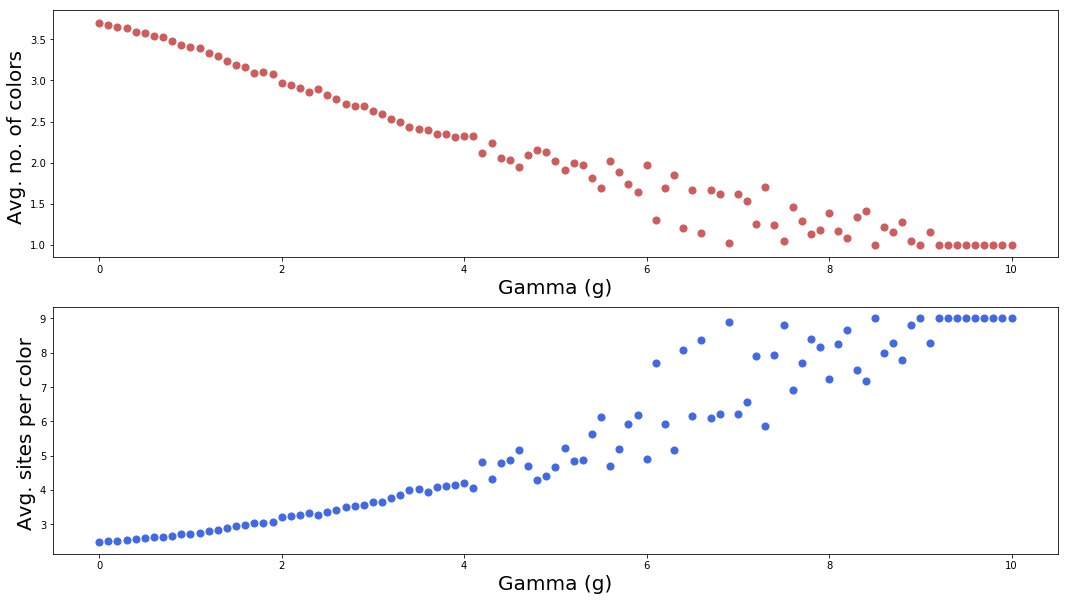

In [12]:
experiment_for_N (3,4) # Non-brute force version

((25,), (24, 1), (23, 2), (23, 1, 1), (22, 3), (22, 2, 1), (22, 1, 1, 1), (21, 4), (21, 3, 1), (21, 2, 2), (21, 2, 1, 1), (21, 1, 1, 1, 1), (20, 5), (20, 4, 1), (20, 3, 2), (20, 3, 1, 1), (20, 2, 2, 1), (20, 2, 1, 1, 1), (20, 1, 1, 1, 1, 1), (19, 6), (19, 5, 1), (19, 4, 2), (19, 4, 1, 1), (19, 3, 3), (19, 3, 2, 1), (19, 3, 1, 1, 1), (19, 2, 2, 2), (19, 2, 2, 1, 1), (19, 2, 1, 1, 1, 1), (19, 1, 1, 1, 1, 1, 1), (18, 7), (18, 6, 1), (18, 5, 2), (18, 5, 1, 1), (18, 4, 3), (18, 4, 2, 1), (18, 4, 1, 1, 1), (18, 3, 3, 1), (18, 3, 2, 2), (18, 3, 2, 1, 1), (18, 3, 1, 1, 1, 1), (18, 2, 2, 2, 1), (18, 2, 2, 1, 1, 1), (18, 2, 1, 1, 1, 1, 1), (18, 1, 1, 1, 1, 1, 1, 1), (17, 8), (17, 7, 1), (17, 6, 2), (17, 6, 1, 1), (17, 5, 3), (17, 5, 2, 1), (17, 5, 1, 1, 1), (17, 4, 4), (17, 4, 3, 1), (17, 4, 2, 2), (17, 4, 2, 1, 1), (17, 4, 1, 1, 1, 1), (17, 3, 3, 2), (17, 3, 3, 1, 1), (17, 3, 2, 2, 1), (17, 3, 2, 1, 1, 1), (17, 3, 1, 1, 1, 1, 1), (17, 2, 2, 2, 2), (17, 2, 2, 2, 1, 1), (17, 2, 2, 1, 1, 1, 1), (1

1 7.0 3.5714285714285716
1001 7.69030969030969 3.267357642357635
2001 7.705147426286857 3.260453106779925
3001 7.710096634455182 3.258110391774179
4001 7.706073481629592 3.2596910296236024
5001 7.708458308338332 3.2584971101018696
[[7 2 1 7 0]
 [7 6 3 7 3]
 [5 4 1 1 3]
 [3 1 5 3 2]
 [3 6 2 2 3]]
7.708691308691309 3.258390419104785

1  - gamma: 0.1
[0.09516258 0.08610666 0.07791253 0.07049817 0.06378939 0.05771902
 0.05222633 0.4965853 ]
1 8.0 3.125
1001 7.682317682317683 3.2715201465201416
2001 7.681159420289855 3.2715487494347886
3001 7.6851049650116625 3.269654162898098
4001 7.687578105473632 3.268394210971129
5001 7.690461907618476 3.26676926519467
[[4 7 3 4 0]
 [3 7 0 0 3]
 [4 1 1 2 1]
 [3 5 3 2 6]
 [3 1 2 1 1]]
7.69070929070929 3.266655963084624

2  - gamma: 0.2
[0.18126925 0.14841071 0.12150841 0.09948267 0.08144952 0.06668523
 0.05459725 0.24659696]
1 8.0 3.125
1001 7.635364635364636 3.2944139194139104
2001 7.647176411794103 3.2880583517764728
3001 7.6411196267910695 3.291204519

1 7.0 3.5714285714285716
1001 6.94005994005994 3.653429903429881
2001 6.948025987006496 3.6444277861069407
3001 6.981672775741419 3.626608590787249
4001 6.978005498625343 3.6297696409232145
5001 6.9514097180563885 3.6462588434695036
[[6 4 6 5 0]
 [1 5 3 2 1]
 [1 5 1 6 3]
 [1 1 4 2 0]
 [4 3 4 2 6]]
6.951248751248751 3.646317967746641

19  - gamma: 1.9000000000000001
[8.50431381e-01 1.27197847e-01 1.90248064e-02 2.84551402e-03
 4.25599604e-04 6.36563450e-05 9.52099163e-06 1.67449321e-06]
1 8.0 3.125
1001 6.842157842157842 3.7129239807810905
2001 6.8745627186406795 3.691651198210406
3001 6.8740419860046655 3.690099331968731
4001 6.881529617595601 3.6850311231716533
5001 6.887022595480904 3.6835847116291456
[[2 2 6 6 1]
 [2 6 5 3 2]
 [5 1 7 4 6]
 [5 4 5 4 0]
 [5 3 2 7 7]]
6.887912087912088 3.68313829028119

20  - gamma: 2.0
[8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 8.31528719e-07]
1 8.0 3.125
1001 6.856143856143857 3.69071404

4001 5.688077980504874 4.487434688946815
5001 5.653269346130774 4.518995010521768
[[5 7 7 5 0]
 [5 5 6 5 6]
 [6 0 0 5 6]
 [5 1 1 7 7]
 [0 1 6 7 1]]
5.652747252747253 4.519379430093778

36  - gamma: 3.6
[9.72676278e-01 2.65771366e-02 7.26186305e-04 1.98421130e-05
 5.42160390e-07 1.48138400e-08 4.04769253e-10 1.13704867e-11]
1 5.0 5.0
1001 5.8671328671328675 4.376159554730956
2001 5.853573213393303 4.378435782108964
3001 5.837054315228257 4.398613160692433
4001 5.827293176705823 4.397591078420861
5001 5.739052189562088 4.472861380104979
[[2 6 6 1 5]
 [3 6 1 6 0]
 [2 5 6 2 2]
 [2 3 2 0 2]
 [5 3 5 3 0]]
5.7392607392607395 4.472616669045288

37  - gamma: 3.7
[9.75276474e-01 2.41122737e-02 5.96140437e-04 1.47386939e-05
 3.64392488e-07 9.00906733e-09 2.22735915e-10 5.64641661e-12]
1 5.0 5.0
1001 5.887112887112887 4.332185671471348
2001 5.781609195402299 4.424305704290716
3001 5.703098967010996 4.47940964123067
4001 5.690577355661085 4.499068685209658
5001 5.70745850829834 4.484781615105606
[[

1 4.0 6.25
1001 4.853146853146853 5.233100233100228
2001 4.975512243878061 5.115537469360584
3001 4.779073642119293 5.332785896764587
4001 4.71457135716071 5.411236476595178
5001 4.737052589482103 5.38660125117839
[[7 5 0 0 5]
 [1 1 6 7 7]
 [0 0 0 5 7]
 [1 4 1 5 7]
 [1 0 0 4 5]]
4.738061938061938 5.3856262784834765

54  - gamma: 5.4
[9.95483419e-01 4.49618144e-03 2.03073674e-05 9.17198686e-08
 4.14260211e-10 1.87103977e-12 8.45070258e-15 3.83414545e-17]
1 4.0 6.25
1001 4.462537462537463 5.671828171828172
2001 4.5187406296851576 5.6088622355488935
3001 4.6324558480506495 5.492197045429267
4001 4.6128467883029245 5.517311148403362
5001 4.495500899820036 5.657320916769017
[[5 5 1 5 1]
 [5 2 2 1 6]
 [1 2 2 5 1]
 [1 2 1 1 2]
 [2 2 2 1 6]]
4.4951048951048955 5.657794586366004

55  - gamma: 5.5
[9.95913229e-01 4.07006974e-03 1.66334448e-05 6.79770870e-08
 2.77806817e-10 1.13533297e-12 4.63984634e-15 1.90398028e-17]
1 4.0 6.25
1001 4.734265734265734 5.352147852147845
2001 4.090454772613693 6.3

1 4.0 6.25
1001 4.027972027972028 6.215034965034965
2001 3.833583208395802 6.608362485424064
3001 3.7120959680106633 6.857575252693635
4001 3.7498125468632844 6.777055736066008
5001 3.7540491901619677 6.767063254015827
[[6 3 6 1 7]
 [3 3 1 6 7]
 [6 6 7 1 3]
 [1 1 1 3 7]
 [3 7 7 6 6]]
3.7542457542457544 6.766650016649981

72  - gamma: 7.2
[9.99253414e-01 7.46028418e-04 5.56974230e-07 4.15829055e-10
 3.10452071e-13 2.31779111e-16 1.73042995e-19 1.29287969e-22]
1 4.0 6.25
1001 4.0 6.25
2001 4.164917541229386 6.047601199400295
3001 4.121292902365878 6.100883038987001
4001 3.9280179955011247 6.477651420478013
5001 3.764647070585883 6.802472838765313
[[3 4 1 4 4]
 [3 1 1 3 1]
 [4 3 1 3 3]
 [4 3 1 1 1]
 [1 3 1 4 1]]
3.764035964035964 6.803696303696039

73  - gamma: 7.300000000000001
[9.99324461e-01 6.75082423e-04 4.56044353e-07 3.08075644e-10
 2.08117043e-13 1.40591132e-16 9.49747613e-20 6.42025052e-23]
1 3.0 8.333333333333334
1001 4.0639360639360635 6.4177489177489235
2001 3.8305847076461768

3001 3.8363878707097636 6.590858602688091
4001 3.8772806798300423 6.505665250354152
5001 3.750449910017996 6.769896020795811
[[2 2 4 4 4]
 [4 6 6 2 2]
 [4 4 4 4 6]
 [2 2 6 6 2]
 [6 6 6 2 6]]
3.74985014985015 6.771145521145494

90  - gamma: 9.0
[9.99876590e-01 1.23394574e-04 1.52281002e-08 1.87929686e-12
 2.31923658e-16 2.86216532e-20 3.53219261e-24 4.35961000e-28]
1 3.0 8.333333333333334
1001 3.0 8.333333333333226
2001 2.815592203898051 9.101699150424926
3001 2.5438187270909696 10.234088637121053
4001 2.4078980254936266 10.800424893776626
5001 2.3263347330533892 11.140271945610934
[[3 3 3 3 3]
 [3 3 3 3 1]
 [1 1 1 3 1]
 [1 3 1 3 1]
 [1 3 3 3 3]]
2.326073926073926 11.141358641358696

91  - gamma: 9.1
[9.99888334e-01 1.11653339e-04 1.24678604e-08 1.39223371e-12
 1.55464903e-16 1.73601141e-20 1.93853117e-24 2.16491826e-28]
1 3.0 8.333333333333334
1001 3.0 8.333333333333226
2001 3.0 8.33333333333355
3001 3.0 8.333333333333075
4001 3.0 8.333333333332899
5001 3.0967806438712255 8.13170699193

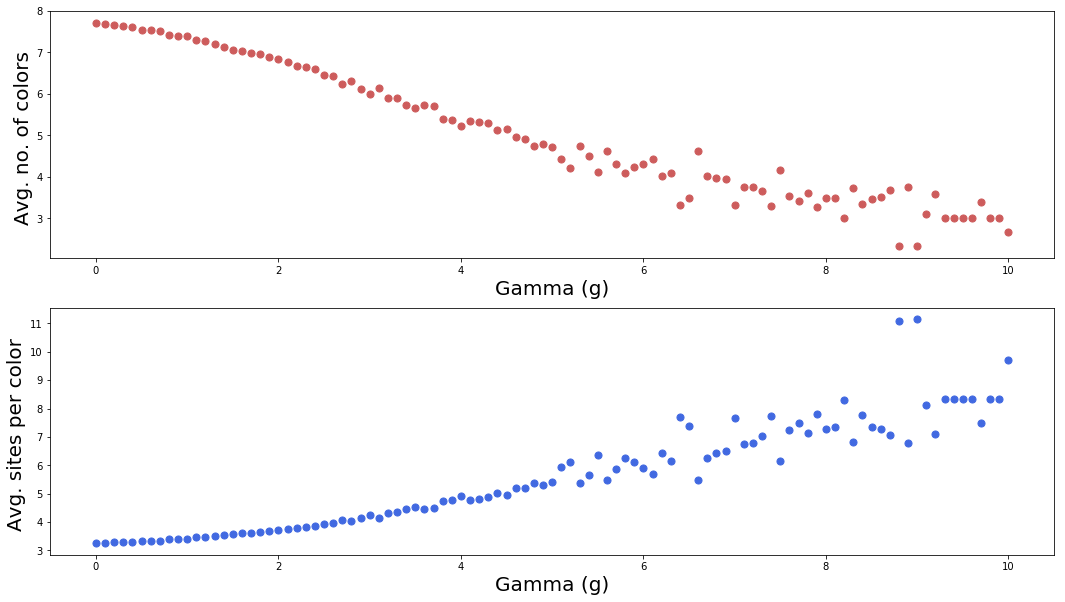

In [13]:
experiment_for_N (5,8) # Non-brute force version